# Capacitated Vehicle Routing with Time Window

## Inizializzazione

### Librerie

In [1]:
import gurobipy as gb
from gurobipy import *
import re
import random
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.pyplot as plt
'''
def distance(city1, city2):
    i = coordinate[city1]
    j = coordinate[city2]
    diff = (i[0]-j[0], i[1]-j[1])
    return math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])
'''
   

plt.rcParams["figure.figsize"] = (20,10)

### Classi

In [2]:
class Node:
    def __init__(self, number, coordinate, demand, rdy_time, due_date, serv_time):
        self.number = number
        self.coordinate = coordinate
        self.demand = demand
        self.rdy_time = rdy_time
        self.due_date = due_date
        self.service_time = serv_time
    
    def distance(self, node):
        i = self.coordinate
        j = node.coordinate
        diff = (i[0]-j[0], i[1]-j[1])
        return math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])
    
    def travel_time(self,node):
        return round(self.distance(node),1)

In [3]:
class CPVRTW:
    def __init__(self, file_name, num_nodes):
        self.num_nodes = num_nodes
        self.nodes = []
        f = open(file_name, "r")
        for i in range(4) :
            line = f.readline()    

        line = f.readline()
        data  = re.findall(r"[-+]?\d.\d+|\d+", line)
        self.num_vehicle = int(data[0])
        self.capacity = int(data[1])

        for i in range(4) :
            line = f.readline()    #   | Salto altre 4 linee

        for i in range(num_nodes) :
            line = f.readline()
            data = re.findall(r"[-+]?\d.\d+|\d+", line)
            coordinate = (int(data[1]), int(data[2]))
            demand = int(data[3])
            rdy_time = int(data[4])
            due_date = int(data[5])
            serv_time = int(data[6])
            self.nodes.append(Node(i,coordinate,demand,rdy_time,due_date,serv_time))
        f.close()

        self.calculate_distances()
        self.calculate_travel_times()
    
    def calculate_distances (self):
        self.distances = {(i,j): self.nodes[i].distance(self.nodes[j]) for i in range(self.num_nodes) for j in range(self.num_nodes) if i!=j}

    def calculate_travel_times(self):
        self.travel_times = {(i,j): round(self.distances[i,j],1) for i in range(self.num_nodes) for j in range(self.num_nodes) if i != j}
    
    def calculate_routes_from_model(self,x):
        node = []
        for i in range(1,self.num_nodes):
            if x[0,i]>0:
                node.append(i)

        route = []
        self.routes = []
        for k in node:
            next = k
            route.append(k)
            stop = 1
            while stop:
                for i in range(self.num_nodes):
                    if i==0 and x[next,i] == 1:
                        stop = 0
                    elif x[next,i] == 1:
                        route.append(i)
                        next = i

            self.routes.append(route)
            route = []
        

### Lettura del file e memorizzazione dei dati

$num\_nodes$  Numero di nodi <br>
$num\_vehicle$ Numero di veicoli <br>
$capacity$ Capacità di ogni veicolo (uguale per tutti) <br>
$demand_i$ Domanda di ogni cliente i da soddisfare <br>
$time\_window_i$ Finestra temporale di servizio per ogni cliente i <br>
$coordinate$ Posizione nello spazio di ogni nodo <br>
$travel\_time_{i,j}$ Tempo di percorrenza per raggiungere il cliente j partendo dal cliente i <br>
$dist_{i,j}$ Distanza euclidea tra il cliente i e il cliente j

In [4]:
file_name = "VRPTW-Instances/Solomon/C101.txt"
instance = CPVRTW(file_name, 100)

## Modellazione

### Variabili

$x_{i,j}$ Variabile binaria (1 se l'arco è attraversato da un veicolo, 0 altrimenti) <br>
$u_i$ Quantità di domanda servita dal veicolo nel percorso dal deposito al nodo i <br>
$a_i$ Tempo di arrivo nel nodo $i$

In [5]:
mod = gb.Model('CVRP')
x = mod.addVars(range(instance.num_nodes), range(instance.num_nodes),vtype=GRB.BINARY, name="X")
u = mod.addVars(range(instance.num_nodes),vtype=GRB.INTEGER, name="Y")
a = mod.addVars(range(instance.num_nodes), vtype=GRB.INTEGER,name="A")

Academic license - for non-commercial use only - expires 2021-08-10
Using license file C:\Users\Giuseppe\Universita\x\gurobi.lic


### Vincoli

Se un veicolo entra nel nodo $i$ deve anche uscirne
$$\sum_{j=0}^{n} x_{i,j} - \sum_{j=0}^{n} x_{j,i} = 0 \quad \forall i \in \{0,1,2,...,n\}$$

In [6]:
mod.addConstrs((x.sum(i,'*') - x.sum('*',i)  == 0 for i in range(instance.num_nodes)), name="Trasporto");

Dal deposito devono uscire massimo $m$ veicoli
$$\sum_{j=1}^{n} x_{0j} \leq m $$

In [7]:
mod.addConstr(x.sum(0,'*') - x[0,0] <= instance.num_vehicle, name="NumeroVeicoli");

Ogni cliente deve essere servito da un solo veicolo
$$\sum_{j=0}^{n} x_{i,j} = 1 \quad \forall  i \in \{1,2,...,n\}$$

In [8]:
mod.addConstrs((x.sum(i,'*') == 1 for i in range(1,instance.num_nodes)), name="VeicoliCliente");

Quando il camion arriva al cliente $i$, la domanda totale servita deve essere minore della sua capacità
$$u_i \leq Q \quad \forall i \in V$$ <br>
La domanda iniziale (nel nodo 0) deve essere nulla essendo il deposito
$$u_0 = 0$$

In [9]:
mod.addConstrs((u[i] <= instance.capacity for i in range(instance.num_nodes)), "CapacitàMassima");
mod.addConstr((u[0] == 0), "DomandaIniziale");

Si deve evitare di considerare archi ricorsivi (un camion entra in nodo e va nello stesso nodo)
$$x_{i,i} = 0 \quad \forall i \in {0,1,...,n}$$

In [10]:
mod.addConstrs((x[i,i] == 0 for i in range(instance.num_nodes)), "ArchiRicorsivi");

Per permettere il trasporto, dopo che il veicolo è arrivato ad un nodo si deve assicurare che può andare in quello successivo. Bisogna controllare che la richiesta del nodo successivo non supera la capacità corrente del veicolo.

$$u_j - u_i - d_jx_{i,j} + Q(1-x_{i,j}) \geq 0 \quad \forall i,j \in V, \; i\neq j, \; j \neq 0$$

In [11]:
mod.addConstrs(u[j] - u[i] - instance.nodes[j].demand*x[i,j] + instance.capacity*(1-x[i,j]) >= 0 for i in range(instance.num_nodes) for j in range(instance.num_nodes) if i!=j and j!=0);

Un veicolo può arrivare ad un nodo solo se ha completamente servito il nodo precedente
$$a_j \geq (a_i + t_i + t_{ij}) - (1-x_{ij})T \quad \forall i \in \{0,1,...,n\} \; \forall j \in \{1,2,...,n\} \; i \neq j$$
T è un tempo molto grande, si può porre pari al massimo tempo per servire tutti i nodi

In [12]:
mod.addConstrs((a[j] >= (a[i]+instance.nodes[i].service_time+instance.travel_times[i,j]) - (1-x[i,j])*instance.nodes[0].due_date for i in range(instance.num_nodes) for j in range(1,instance.num_nodes) if i!=j),name="TempiDiArrivo");
#mod.addConstrs((a[i] + travel_time[i,0] + serv_time[i] <= time_window[0][1] for i in range(1,num_nodes)),name="TempoDeposito");


Il tempo di arrivo di ogni nodo deve essere compreso nella finestra temporale
$$l_i \leq a_i \leq L_i \quad \forall i \in \{0,1,...,n\}$$

In [13]:
mod.addConstrs((a[i] >= instance.nodes[i].rdy_time for i in range(1,instance.num_nodes)),name="TW_Lower")
mod.addConstrs((a[i] <= instance.nodes[i].due_date for i in range(1,instance.num_nodes)),name="TW_Upper");

### Funzione obiettivo

Minimizzare i costi di trasporto totali
$$min \sum_{i=1}^{n}\sum_{j=1}^{n} c_{i,j}x_{i,j} \quad i \neq j$$

In [14]:
obj = (gb.quicksum(instance.distances[i,j]*x[i,j] for i in range(instance.num_nodes) for j in range(instance.num_nodes) if i!=j))
mod.setObjective(obj, GRB.MINIMIZE)

In [15]:
mod.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 20201 rows, 10200 columns and 89004 nonzeros
Model fingerprint: 0x6201a671
Variable types: 0 continuous, 10200 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 16344 rows and 5618 columns
Presolve time: 0.24s
Presolved: 3857 rows, 4582 columns, 20191 nonzeros
Variable types: 0 continuous, 4582 integer (4411 binary)

Root relaxation: objective 8.201517e+02, 337 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  820.15174    0   44          -  820.15174      -     -    0s
H    0     0                    1151.1039159  820.15174  28.8%     -    0s
H    0

## Grafico

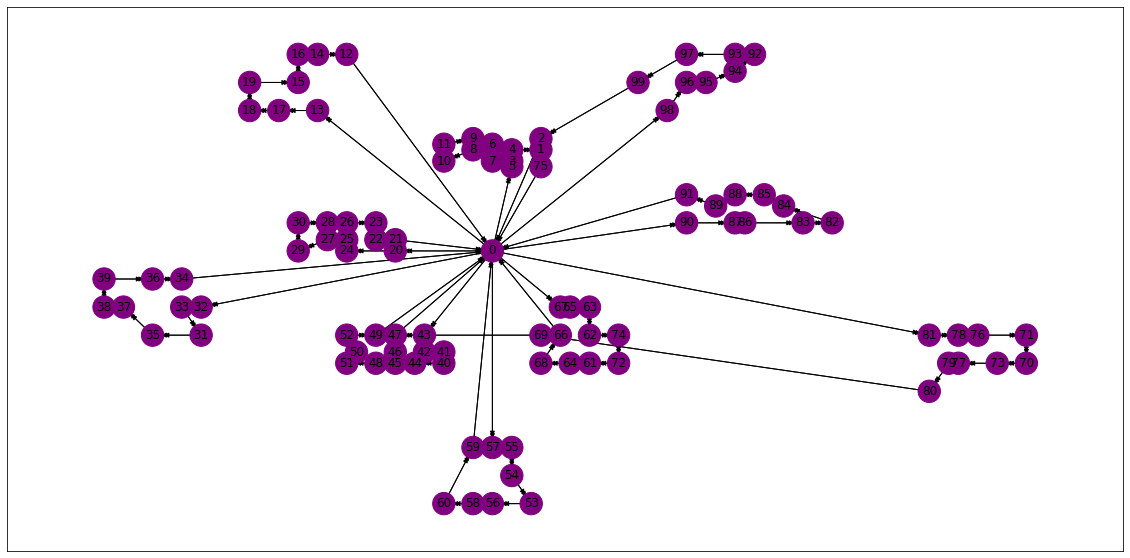

In [16]:

Graph = nx.DiGraph()
list_nodes = list(range(instance.num_nodes))
Graph.add_nodes_from(list_nodes)
for i in range(instance.num_nodes):
    for j in range(instance.num_nodes) :
        if i!=j and x[i,j].x == 1 :
            Graph.add_edge(i,j)

dict_dem = {}
for i in range(instance.num_nodes) :
    dict_dem[i] = instance.nodes[i].demand
coordinate = {}
for i in range(instance.num_nodes):
     coordinate[i] = instance.nodes[i].coordinate
# Colora di rosso i nodi della soluzione e di verde gli altri
node_col = ['purple' for node in Graph.nodes()]
# Colora di rosso gli archi della soluzione e di nero gli altri
edge_col = ['black' for edge in Graph.edges()]
# Draw the nodes
nx.draw_networkx(Graph,coordinate, node_color= node_col, node_size=500)
# Draw the edges
nx.draw_networkx_edges(Graph, coordinate,edge_color= edge_col)
# Show the plot
#nx.draw_networkx_labels(Graph,coordinate,labels= dict_dem,horizontalalignment='center',verticalalignment='bottom')

plt.show()

In [17]:
X = mod.getAttr('x', x)
instance.calculate_routes_from_model(X)
for i in range(len(instance.routes)) :
    print(instance.routes[i])    

[5, 3, 7, 8, 10, 11, 9, 6, 4, 1, 75]
[13, 17, 18, 19, 15, 16, 14, 12]
[20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21]
[32, 33, 31, 35, 37, 38, 39, 36, 34]
[43, 42, 41, 40, 44, 46, 45, 48, 51, 50, 52, 49]
[57, 55, 54, 53, 56, 58, 60, 59]
[67, 65, 63, 62, 74, 72, 61, 64, 68, 66]
[81, 78, 76, 71, 70, 73, 77, 79, 80, 69, 47]
[90, 87, 86, 83, 82, 84, 85, 88, 89, 91]
[98, 96, 95, 94, 92, 93, 97, 99, 2]


----------------------------------------------------------------------------------------------------------------------

# Algoritmo Genetico

## Ricerca delle soluzioni iniziali

In [170]:

def nodi_raggiungibili(lista_nodi, nodo_iniziale, tempo_iniziale, capacita_rimanente, tolleranza):
    ragg_nodes = []
    for k in lista_nodi:
        node = k
        if nodo_iniziale.number != node.number:
            if node.demand < capacita_rimanente:
                tt = node.travel_time(nodo_iniziale) + nodo_iniziale.service_time + tempo_iniziale
                if tt < node.due_date and tt > node.rdy_time-tolleranza:
                    print("Nodo: ",node.number,"\t[",node.rdy_time,", ",node.due_date,"] \t- Travel and Service Time: ", tt)
                    ragg_nodes.append(node)
    return ragg_nodes

In [209]:
ragg_nodes = []
solution = []
times = [] #Lista dei tempi di arrivo in ogni nodo
list_nodes = []
for i in range(instance.num_nodes):
    list_nodes.append(instance.nodes[i])
deposito = list_nodes[0]
list_nodes.remove(deposito)
solution.append(deposito)

remain_capacity = instance.capacity
next_node = deposito
route_time = 0
k = 1
print("Veicolo: ",k)
stp = 1
wait_time = 0
stp_ext = 1
while stp_ext == 1:
    while stp == 1:
        
        ragg_nodes = nodi_raggiungibili(list_nodes, next_node, route_time, remain_capacity, 100)
        if len(ragg_nodes) == 0:
            print("Nessun nodo raggiungibile")
            solution.append(deposito)
            remain_capacity = instance.capacity
            next_node = deposito
            route_time = 0
            k = k+1
            if k > instance.num_vehicle:
                stp = 0
                k=0
            print("\n\nVeicolo: ",k)
        else:
            from_node = next_node
            print("Nodo iniziale: ", from_node.number)
            next_node = random.choice(ragg_nodes)
            print("Prossimo nodo: ",next_node.number, "Richiesta: ", next_node.demand)
            remain_capacity -= next_node.demand
            print("Capacità rimanente: ",remain_capacity)
            route_time = route_time + from_node.service_time + from_node.travel_time(next_node)
            wait_time = next_node.rdy_time - route_time
            if wait_time < 0: #Il veicolo è arrivato in tempo
                wait_time = 0
            route_time += wait_time
            times.append(route_time)
            print("Tempo corrente: ",route_time)
            print("Tempo di attesa: ",wait_time)
            solution.append(next_node)
            list_nodes.remove(next_node)
            if len(list_nodes) == 0:
                stp = 2
    if stp == 2:
        stp_ext = 0
    else:
        solution = []
        list_nodes = []
        times = []
        for i in range(instance.num_nodes):
            list_nodes.append(instance.nodes[i]) 
        deposito = list_nodes[0]
        list_nodes.remove(deposito)
        solution.append(deposito)
        stp = 1

Veicolo:  1
Nodo:  3 	[ 65 ,  146 ] 	- Travel and Service Time:  16.1
Nodo:  5 	[ 15 ,  67 ] 	- Travel and Service Time:  15.1
Nodo:  13 	[ 30 ,  92 ] 	- Travel and Service Time:  30.8
Nodo:  17 	[ 99 ,  148 ] 	- Travel and Service Time:  33.3
Nodo:  20 	[ 10 ,  73 ] 	- Travel and Service Time:  10.0
Nodo:  24 	[ 65 ,  144 ] 	- Travel and Service Time:  15.0
Nodo:  32 	[ 31 ,  100 ] 	- Travel and Service Time:  31.6
Nodo:  33 	[ 87 ,  158 ] 	- Travel and Service Time:  33.5
Nodo:  42 	[ 68 ,  149 ] 	- Travel and Service Time:  19.3
Nodo:  43 	[ 16 ,  80 ] 	- Travel and Service Time:  16.6
Nodo:  55 	[ 95 ,  158 ] 	- Travel and Service Time:  35.1
Nodo:  57 	[ 35 ,  87 ] 	- Travel and Service Time:  35.0
Nodo:  65 	[ 76 ,  129 ] 	- Travel and Service Time:  12.8
Nodo:  67 	[ 12 ,  77 ] 	- Travel and Service Time:  12.2
Nodo:  78 	[ 109 ,  170 ] 	- Travel and Service Time:  50.3
Nodo:  81 	[ 47 ,  124 ] 	- Travel and Service Time:  47.4
Nodo:  87 	[ 85 ,  144 ] 	- Travel and Service Time

Nodo:  95 	[ 196 ,  239 ] 	- Travel and Service Time:  202.6
Nodo iniziale:  24
Prossimo nodo:  18 Richiesta:  20
Capacità rimanente:  170
Tempo corrente:  181.9
Tempo di attesa:  0
Nodo:  8 	[ 255 ,  324 ] 	- Travel and Service Time:  295.9
Nodo:  10 	[ 357 ,  410 ] 	- Travel and Service Time:  293.8
Nodo:  19 	[ 278 ,  345 ] 	- Travel and Service Time:  276.9
Nodo:  27 	[ 261 ,  316 ] 	- Travel and Service Time:  296.3
Nodo:  29 	[ 358 ,  405 ] 	- Travel and Service Time:  297.4
Nodo:  35 	[ 283 ,  344 ] 	- Travel and Service Time:  313.1
Nodo:  37 	[ 383 ,  434 ] 	- Travel and Service Time:  309.2
Nodo:  44 	[ 359 ,  412 ] 	- Travel and Service Time:  320.0
Nodo:  56 	[ 385 ,  436 ] 	- Travel and Service Time:  346.20000000000005
Nodo:  70 	[ 387 ,  456 ] 	- Travel and Service Time:  363.70000000000005
Nodo:  74 	[ 353 ,  412 ] 	- Travel and Service Time:  327.1
Nodo:  82 	[ 369 ,  420 ] 	- Travel and Service Time:  335.1
Nodo:  83 	[ 265 ,  338 ] 	- Travel and Service Time:  332.3


Nodo:  88 	[ 645 ,  708 ] 	- Travel and Service Time:  602.8
Nodo:  97 	[ 561 ,  622 ] 	- Travel and Service Time:  601.2
Nodo iniziale:  11
Prossimo nodo:  26 Richiesta:  10
Capacità rimanente:  110
Tempo corrente:  622.0
Tempo di attesa:  33.299999999999955
Nodo:  2 	[ 825 ,  870 ] 	- Travel and Service Time:  737.0
Nodo:  4 	[ 727 ,  782 ] 	- Travel and Service Time:  733.4
Nodo:  22 	[ 812 ,  883 ] 	- Travel and Service Time:  716.2
Nodo:  23 	[ 732 ,  777 ] 	- Travel and Service Time:  715.0
Nodo:  34 	[ 751 ,  816 ] 	- Travel and Service Time:  731.7
Nodo:  50 	[ 815 ,  880 ] 	- Travel and Service Time:  735.0
Nodo:  51 	[ 725 ,  786 ] 	- Travel and Service Time:  737.0
Nodo:  68 	[ 734 ,  777 ] 	- Travel and Service Time:  744.0
Nodo:  80 	[ 769 ,  820 ] 	- Travel and Service Time:  779.1
Nodo:  89 	[ 737 ,  802 ] 	- Travel and Service Time:  750.1
Nodo:  91 	[ 836 ,  889 ] 	- Travel and Service Time:  747.4
Nodo iniziale:  26
Prossimo nodo:  91 Richiesta:  10
Capacità rimanente

Nodo:  73 	[ 478 ,  551 ] 	- Travel and Service Time:  430.1
Nodo:  84 	[ 458 ,  523 ] 	- Travel and Service Time:  435.0
Nodo:  93 	[ 475 ,  518 ] 	- Travel and Service Time:  458.7
Nodo iniziale:  53
Prossimo nodo:  58 Richiesta:  30
Capacità rimanente:  130
Tempo corrente:  471.0
Tempo di attesa:  89.0
Nodo:  6 	[ 621 ,  702 ] 	- Travel and Service Time:  625.0
Nodo:  36 	[ 665 ,  716 ] 	- Travel and Service Time:  612.9
Nodo:  45 	[ 541 ,  600 ] 	- Travel and Service Time:  587.2
Nodo:  48 	[ 632 ,  693 ] 	- Travel and Service Time:  587.9
Nodo:  60 	[ 562 ,  629 ] 	- Travel and Service Time:  564.0
Nodo:  61 	[ 531 ,  610 ] 	- Travel and Service Time:  588.7
Nodo:  64 	[ 632 ,  693 ] 	- Travel and Service Time:  587.9
Nodo:  77 	[ 574 ,  643 ] 	- Travel and Service Time:  616.9
Nodo:  79 	[ 668 ,  731 ] 	- Travel and Service Time:  616.0
Nodo:  88 	[ 645 ,  708 ] 	- Travel and Service Time:  622.3
Nodo iniziale:  58
Prossimo nodo:  64 Richiesta:  10
Capacità rimanente:  120
Tempo 

Nodo:  6 	[ 621 ,  702 ] 	- Travel and Service Time:  580.0
Nodo:  9 	[ 534 ,  605 ] 	- Travel and Service Time:  582.2
Nodo:  14 	[ 567 ,  620 ] 	- Travel and Service Time:  603.1
Nodo:  36 	[ 665 ,  716 ] 	- Travel and Service Time:  614.3
Nodo:  45 	[ 541 ,  600 ] 	- Travel and Service Time:  596.8
Nodo:  48 	[ 632 ,  693 ] 	- Travel and Service Time:  598.5
Nodo:  60 	[ 562 ,  629 ] 	- Travel and Service Time:  611.5
Nodo:  61 	[ 531 ,  610 ] 	- Travel and Service Time:  582.4
Nodo:  77 	[ 574 ,  643 ] 	- Travel and Service Time:  581.3
Nodo:  79 	[ 668 ,  731 ] 	- Travel and Service Time:  580.8
Nodo:  85 	[ 555 ,  612 ] 	- Travel and Service Time:  550.8
Nodo:  88 	[ 645 ,  708 ] 	- Travel and Service Time:  553.4
Nodo:  97 	[ 561 ,  622 ] 	- Travel and Service Time:  576.8
Nodo iniziale:  84
Prossimo nodo:  77 Richiesta:  10
Capacità rimanente:  130
Tempo corrente:  581.3
Tempo di attesa:  0
Nodo:  2 	[ 825 ,  870 ] 	- Travel and Service Time:  730.0
Nodo:  4 	[ 727 ,  782 ] 	- 

Nodo:  15 	[ 384 ,  429 ] 	- Travel and Service Time:  311.0
Nodo:  19 	[ 278 ,  345 ] 	- Travel and Service Time:  314.2
Nodo:  29 	[ 358 ,  405 ] 	- Travel and Service Time:  292.6
Nodo:  35 	[ 283 ,  344 ] 	- Travel and Service Time:  306.3
Nodo:  40 	[ 264 ,  321 ] 	- Travel and Service Time:  279.0
Nodo:  56 	[ 385 ,  436 ] 	- Travel and Service Time:  297.4
Nodo:  70 	[ 387 ,  456 ] 	- Travel and Service Time:  307.1
Nodo:  71 	[ 293 ,  360 ] 	- Travel and Service Time:  306.3
Nodo:  82 	[ 369 ,  420 ] 	- Travel and Service Time:  290.2
Nodo:  83 	[ 265 ,  338 ] 	- Travel and Service Time:  287.6
Nodo iniziale:  63
Prossimo nodo:  70 Richiesta:  30
Capacità rimanente:  110
Tempo corrente:  387.0
Tempo di attesa:  79.89999999999998
Nodo:  6 	[ 621 ,  702 ] 	- Travel and Service Time:  544.4
Nodo:  9 	[ 534 ,  605 ] 	- Travel and Service Time:  546.6
Nodo:  14 	[ 567 ,  620 ] 	- Travel and Service Time:  568.4
Nodo:  45 	[ 541 ,  600 ] 	- Travel and Service Time:  542.0
Nodo:  48 	

Capacità rimanente:  170
Tempo corrente:  222.7
Tempo di attesa:  0
Nodo:  29 	[ 358 ,  405 ] 	- Travel and Service Time:  330.7
Nodo iniziale:  31
Prossimo nodo:  29 Richiesta:  10
Capacità rimanente:  160
Tempo corrente:  358.0
Tempo di attesa:  27.30000000000001


In [210]:
print("Nodi non esplorati: ", len(list_nodes))
print("Veicoli utilizzati: ",k)
for u in solution:
    print(u.number)
times

Nodi non esplorati:  0
Veicoli utilizzati:  18
0
87
76
38
59
66
75
47
0
24
18
37
30
12
99
21
49
0
67
41
74
11
26
91
1
0
57
95
8
16
39
80
52
0
98
53
58
64
34
69
0
33
62
10
28
51
22
0
32
94
84
77
4
50
0
43
54
44
85
36
2
0
17
27
92
61
68
0
65
63
70
9
23
0
81
25
83
45
88
89
0
5
78
82
93
97
6
0
20
42
35
15
48
0
13
71
14
0
90
86
19
72
60
0
96
40
46
79
0
3
7
56
73
0
55
31
29


[85.0,
 207.0,
 479.0,
 651.0,
 826.0,
 997.0,
 1120.5,
 65.0,
 181.9,
 383.0,
 496.4,
 652.0,
 772.4,
 914.0,
 1021.1,
 12.2,
 166.0,
 353.0,
 481.5,
 622.0,
 836.0,
 943.0,
 35.0,
 196.0,
 312.8,
 475.0,
 609.7,
 787.0,
 937.8,
 30.8,
 286.0,
 471.0,
 632.0,
 764.7,
 916.0,
 87.0,
 262.0,
 386.4,
 546.0,
 725.0,
 837.2,
 31.6,
 285.0,
 458.0,
 581.3,
 731.0,
 860.4,
 16.6,
 186.0,
 359.0,
 555.0,
 709.8,
 847.0,
 99.0,
 261.0,
 406.0,
 553.6,
 734.0,
 76.0,
 171.0,
 387.0,
 546.6,
 732.0,
 47.4,
 199.8,
 336.90000000000003,
 541.0,
 677.1,
 769.9,
 15.1,
 160.0,
 369.0,
 490.6,
 585.6,
 701.2,
 10.0,
 118.2,
 283.0,
 420.4,
 632.0,
 30.8,
 293.0,
 567.0,
 20.6,
 173.0,
 319.8,
 472.6,
 593.4,
 95.0,
 264.0,
 448.0,
 668.0,
 65.0,
 170.0,
 385.0,
 532.7,
 95.0,
 222.7,
 358.0]